# **Kernel Density Based Clustering**

*   Rohan Niranjan Kalpavruksha
*   Roshan Niranjan Kalpavruksha

## COMPARING **DBSCAN** WITH **VARIOUS KERNEL's** DENSITY BASED CLUSTERING

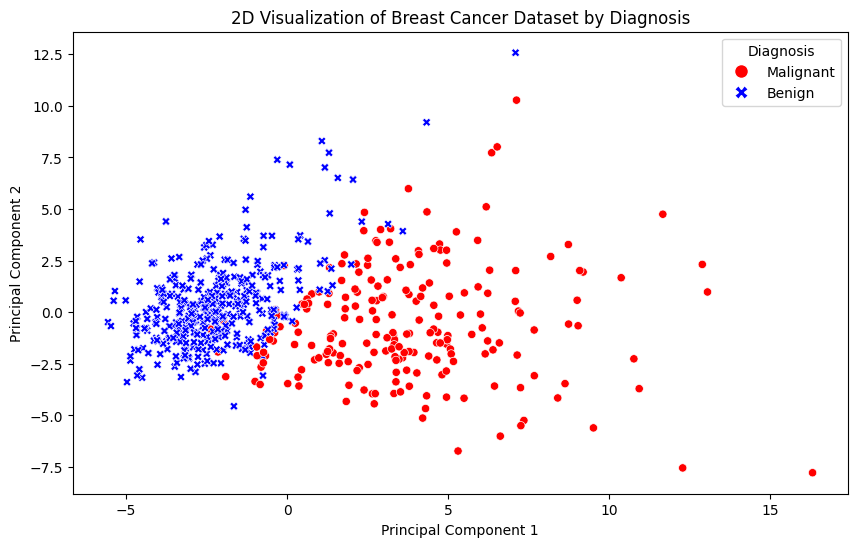

In [6]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# Load dataset
data = pd.read_csv("BreastCancerData.csv")

# Cleaning dataset
data = data.drop(data.columns[-1], axis=1)
data.replace("?", np.NaN, inplace=True)

# Map 'diagnosis' to numeric values (optional: 0 for malignant, 1 for benign)
data['diagnosis'] = data['diagnosis'].map({'M': 0, 'B': 1})

# Extract features and scale them
X = data.drop(['id', 'diagnosis'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot to visualize the data
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=data['diagnosis'],
    palette={0: 'red', 1: 'blue'},
    style=data['diagnosis']
)
plt.title('2D Visualization of Breast Cancer Dataset by Diagnosis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
custom_legend = [Line2D([0], [0], marker='o', color='w', label='Malignant',
                        markerfacecolor='red', markersize=10),
                 Line2D([0], [0], marker='X', color='w', label='Benign',
                        markerfacecolor='blue', markersize=10)]
plt.legend(handles=custom_legend, title='Diagnosis')
plt.show()

## 1. DBSCAN

Adjusted Rand Index for DBSCAN clustering (PCA components): 0.4323705518196553


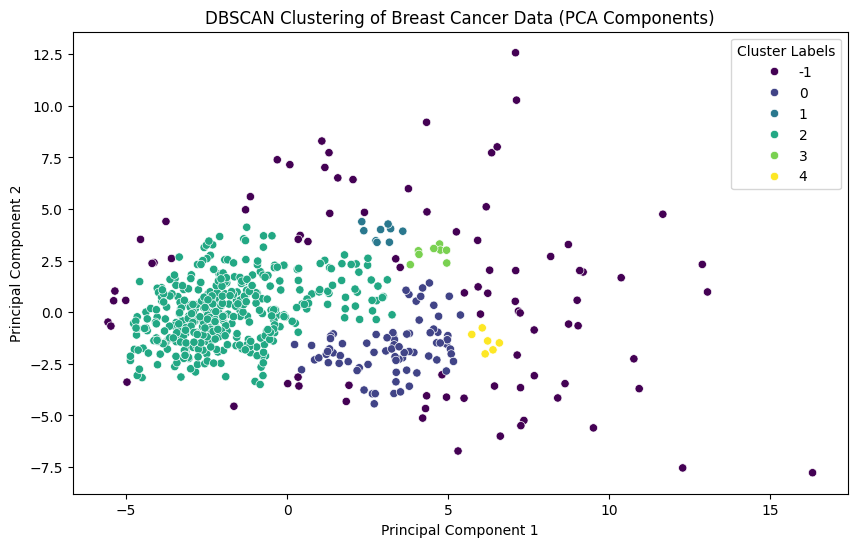

In [31]:
# Import necessary libraries for clustering and evaluation
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply DBSCAN clustering on PCA components (X_pca)
dbscan = DBSCAN(eps=0.7, min_samples=5)  # Adjust eps and min_samples as needed
dbscan_labels = dbscan.fit_predict(X_pca)  # Use PCA components for clustering

# Calculate Adjusted Rand Index (ARI) with ground truth labels
ari_score = adjusted_rand_score(data['diagnosis'], dbscan_labels)
print("Adjusted Rand Index for DBSCAN clustering (PCA components):", ari_score)

# Visualize the clusters after applying DBSCAN
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],   # First principal component
    y=X_pca[:, 1],   # Second principal component
    hue=dbscan_labels,  # Cluster labels from DBSCAN
    palette="viridis",  # Color palette for clusters
    legend='full'
)
plt.title('DBSCAN Clustering of Breast Cancer Data (PCA Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster Labels')
plt.show()

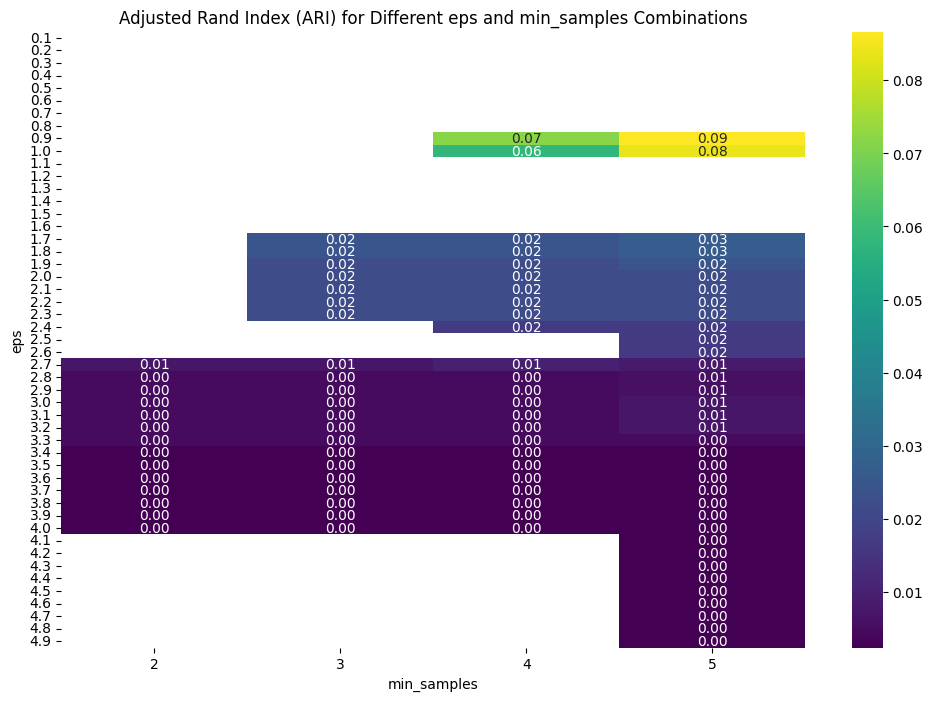

In [15]:
# Adjusted Rand Index (ARI) varies with different values of eps and min_samples for DBSCAN
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define a range of eps and min_samples values
eps_values = np.arange(0.1, 5.0, 0.1)  # Adjust eps values
min_samples_values = range(2, 6)  # Adjust min_samples values

# Initialize a matrix to store ARI scores
ari_scores = np.zeros((len(eps_values), len(min_samples_values)))

# Loop over eps and min_samples combinations
for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        # Apply DBSCAN clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_pca)

        # Calculate ARI score if there is more than one cluster (ignore noise points)
        if len(set(dbscan_labels)) > 1 and len(set(dbscan_labels)) <= 2:  # Restrict to 2 clusters
            ari_score = adjusted_rand_score(data['diagnosis'], dbscan_labels)
            ari_scores[i, j] = ari_score
        else:
            ari_scores[i, j] = np.nan  # Mark invalid combinations with NaN

# Plot the ARI scores as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(ari_scores, annot=True, fmt=".2f", cmap="viridis",
            xticklabels=min_samples_values, yticklabels=np.round(eps_values, 2))
plt.title("Adjusted Rand Index (ARI) for Different eps and min_samples Combinations")
plt.xlabel("min_samples")
plt.ylabel("eps")
plt.show()

## 2. VARIOUS KERNEL's DENSITY BASED CLUSTERING



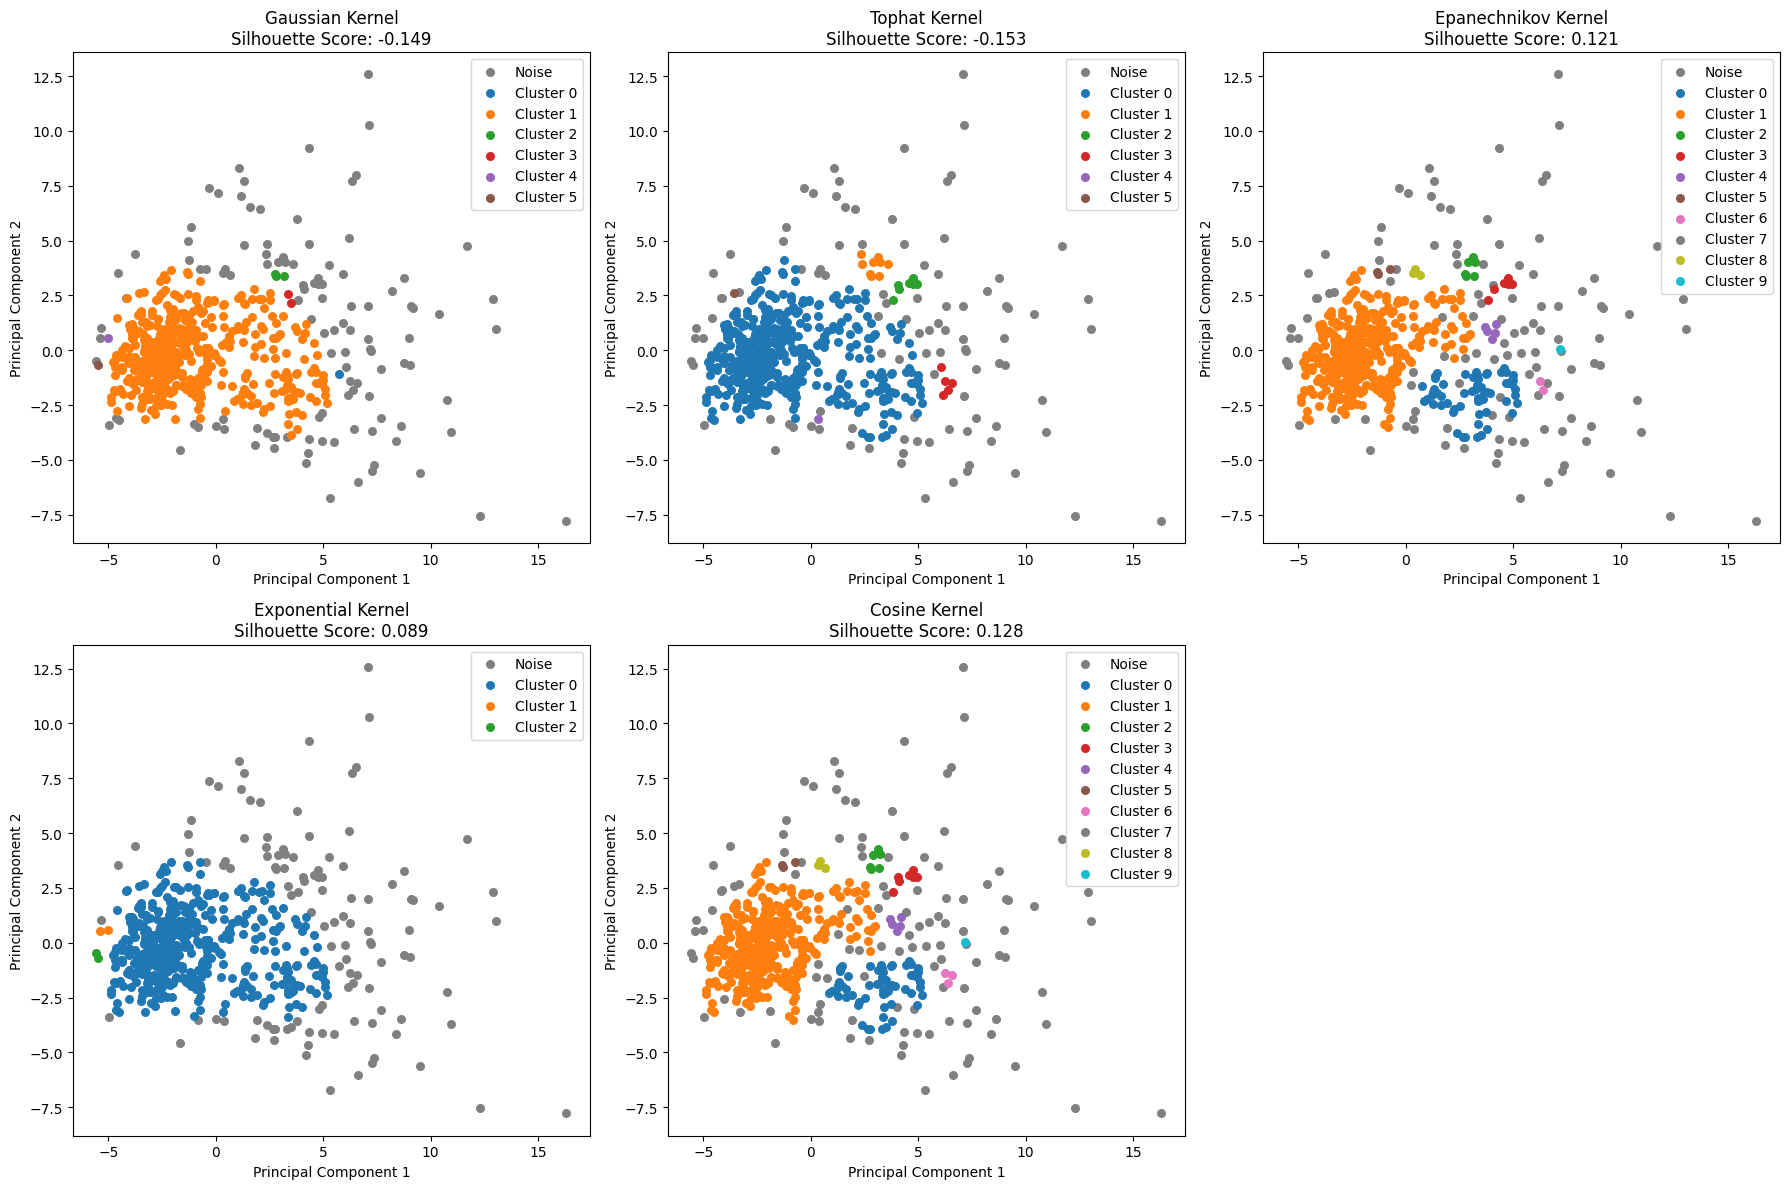

Gaussian Kernel - Silhouette Score: -0.149
Tophat Kernel - Silhouette Score: -0.153
Epanechnikov Kernel - Silhouette Score: 0.121
Exponential Kernel - Silhouette Score: 0.089
Cosine Kernel - Silhouette Score: 0.128


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KernelDensity

# Parameters
h = 0.7  # Bandwidth for density estimation
density_threshold_percentile = 80  # Top 80% as high-density points

# Kernel dictionary (sklearn supports predefined kernels)
kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'cosine']

# Function to perform kernel-based clustering using KernelDensity
def perform_kernel_clustering(X_pca, kernel):
    # Perform Kernel Density Estimation using sklearn's KernelDensity
    kde = KernelDensity(kernel=kernel, bandwidth=h)
    kde.fit(X_pca)

    # Compute log densities for each point
    log_densities = kde.score_samples(X_pca)
    densities = np.exp(log_densities)  # Convert log densities to actual densities

    # Identify high-density points
    density_threshold = np.percentile(densities, 100 - density_threshold_percentile)
    high_density_points = np.where(densities >= density_threshold)[0]

    # Initialize labels for all points as noise (-1)
    labels = np.full(X_pca.shape[0], -1, dtype=int)
    cluster_id = 0

    # Custom clustering logic for high-density points
    for point_idx in high_density_points:
        if labels[point_idx] != -1:  # Already clustered
            continue
        labels[point_idx] = cluster_id
        queue = [point_idx]

        while queue:
            current_point = queue.pop(0)
            for other_idx in high_density_points:
                if labels[other_idx] != -1:  # Skip already labeled points
                    continue
                distance = np.linalg.norm(X_pca[current_point] - X_pca[other_idx])
                # Check if the points are close enough based on the kernel function
                if np.abs(distance) < h:
                    labels[other_idx] = cluster_id
                    queue.append(other_idx)

        cluster_id += 1

    # Calculate silhouette score for high-density points only
    if len(set(labels[high_density_points])) > 1:  # At least 2 clusters
        silhouette = silhouette_score(X_pca[high_density_points], labels[high_density_points])
    else:
        silhouette = -1  # Not enough clusters for silhouette

    return labels, silhouette, densities

# Plot results for each kernel
plt.figure(figsize=(18, 12))
results = {}
for i, kernel in enumerate(kernels):
    all_labels, silhouette, densities = perform_kernel_clustering(X_pca, kernel)
    results[kernel] = silhouette

    # Plot clustering results
    plt.subplot(2, 3, i + 1)
    unique_labels = np.unique(all_labels)
    for label in unique_labels:
        if label == -1:
            plt.scatter(X_pca[all_labels == label, 0], X_pca[all_labels == label, 1],
                        s=30, color='gray', label='Noise')
        else:
            plt.scatter(X_pca[all_labels == label, 0], X_pca[all_labels == label, 1],
                        s=30, label=f'Cluster {label}')

    plt.title(f"{kernel.capitalize()} Kernel\nSilhouette Score: {silhouette:.3f}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()

plt.tight_layout()
plt.show()

# Print silhouette scores
for kernel_name, score in results.items():
    print(f"{kernel_name.capitalize()} Kernel - Silhouette Score: {score:.3f}")